## COVID-19 country comparison

This generates a series of visualizations from the raw data tables, showing some aspects of the ongoing Covid-19 epidemic that I couldn't find in other reports.

Shared on Reddit [here](https://www.reddit.com/r/dataisbeautiful/comments/ff9jn4/oc_number_of_cases_per_country_counting_from_the/).

In [177]:
# Builtins
import datetime
import math
from io import StringIO

# Third party modules
import requests
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from IPython.display import display
import numpy as np
import scipy.optimize

register_matplotlib_converters()
light_grey = (.85, .85, .85, 1) 
matplotlib.rcParams['figure.figsize'] = (14, 8)        # Default size of all figures
matplotlib.rcParams['axes.facecolor'] = light_grey     # Default background color of all graph areas
matplotlib.rcParams['figure.facecolor'] = light_grey   # Default background color of all figure borders
cm = plt.cm.get_cmap('nipy_spectral')                  # This colormap is used for the colors of the plot lines

# Where to get the data
base_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"
data_urls = {
    "confirmed": "time_series_19-covid-Confirmed.csv",
    "deaths":    "time_series_19-covid-Deaths.csv",
    "recovered": "time_series_19-covid-Recovered.csv"    
}

# Convenience function for labelling the y-axis
def set_y_axis_format(log=True):
    if log:
        plt.yscale("log")
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))

### Retrieve the latest version of the data and transform it into a set of Pandas dataframes

Show the first few rows of the confirmed cases dataframe for illustration.

In [178]:
# Set up a dictionary to store all the data in
dataframes = {}
for metric in data_urls.keys():
    url = base_url + data_urls[metric]                             # Combine URL parts
    r = requests.get(url)                                          # Retrieve from URL
    dataframes[metric] = pd.read_csv(StringIO(r.text), sep=",")    # Convert into Pandas dataframe
    
# Display the first 10 lines
display(dataframes["confirmed"].iloc[:15, :])

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20
0,Anhui,Mainland China,31.82570,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.18240,116.4142,14,22,36,41,68,80,...,413,414,414,418,418,422,426,428,428,429
2,Chongqing,Mainland China,30.05720,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.07890,117.9874,1,5,10,18,35,59,...,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.06110,103.8343,0,2,2,4,7,14,...,91,91,91,91,102,119,120,124,124,125
5,Guangdong,Mainland China,23.34170,113.4244,26,32,53,78,111,151,...,1349,1350,1350,1350,1351,1352,1352,1352,1352,1353
6,Guangxi,Mainland China,23.82980,108.7881,2,5,23,23,36,46,...,252,252,252,252,252,252,252,252,252,252
7,Guizhou,Mainland China,26.81540,106.8748,1,3,3,4,5,7,...,146,146,146,146,146,146,146,146,146,146
8,Hainan,Mainland China,19.19590,109.7453,4,5,8,19,22,33,...,168,168,168,168,168,168,168,168,168,168
9,Hebei,Mainland China,38.04280,114.5149,1,1,2,8,13,18,...,318,318,318,318,318,318,318,318,318,318


### Process and add up all provinces/states into one row per country 

In [198]:
for metric in data_urls.keys():
    by_country = dataframes[metric].groupby("Country/Region").sum()           # Group by country
    dates = by_country.columns[2:]                                            # Drop Lat/Long columns
    by_country.loc["All except China", dates] =\
        by_country.sum().loc[dates]-by_country.loc["Mainland China", dates]   # Add "Outside China" row
    by_country = by_country.loc[:, dates].astype(int)                         # Convert to columns to matplotlib dates
    dates = pd.to_datetime(dates)
    by_country.columns = dates

    if metric == "confirmed":
        # Add in some data points for China from before the start of the Johns Hopkins data.
        # Source: https://en.wikipedia.org/wiki/Timeline_of_the_2019%E2%80%9320_coronavirus_outbreak_in_December_2019_%E2%80%93_January_2020
        early_china_data = {
            "1/17/20": 45,
            "1/18/20": 62,
            "1/20/20": 218
        }
        for d, n in early_china_data.items():
            by_country.loc["Mainland China", pd.to_datetime(d)] = n               # Insert early China data point
        by_country = by_country.reindex(list(sorted(by_country.columns)), axis=1) # Retain chronological column order  
        by_country = by_country.fillna(0)
        
        # Correct an odd blip in the Japanese data. 
        # From 2/5 to 2/7, the Johns Hopkins data for Japan goes 22, 45, 25. 
        # I assume that the 45 is incorrect.
        by_country.loc["Japan", pd.to_datetime("2/06/20")] = 23.5      #  Halfway between values for 2/5 and 2/7
        
    by_country = by_country.rename(index={"Republic of Korea": "South Korea", # Change some weird formal names to
                                          "Holy See": "Vatican City",         # more commonly used ones
                                          "Iran (Islamic Republic of)": "Iran",
                                          "Viet Nam": "Vietnam",
                                          "Taipei and environs": "Taiwan",
                                          "Republic of Moldova": "Moldova",
                                          "Russian Federaration": "Russia",
                                          "Others": "Cruise Ship",            # By popular request
                                         })        
        
    dataframes[metric+"_by_country"] = by_country
    
confirmed_by_country = dataframes["confirmed_by_country"]              # Shorthand

with pd.option_context("display.max_rows", 10, "display.max_columns", 10):
    display(dataframes["confirmed_by_country"])

,2020-01-17,2020-01-18,2020-01-20,2020-01-22,2020-01-23,...,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10
Country/Region,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0,0,...,1,1,4,4,5
Albania,0.0,0.0,0.0,0,0,...,0,0,0,2,10
Algeria,0.0,0.0,0.0,0,0,...,17,17,19,20,20
Andorra,0.0,0.0,0.0,0,0,...,1,1,1,1,1
Argentina,0.0,0.0,0.0,0,0,...,2,8,12,12,17
...,...,...,...,...,...,...,...,...,...,...,...
Ukraine,0.0,0.0,0.0,0,0,...,1,1,1,1,1
United Arab Emirates,0.0,0.0,0.0,0,0,...,29,45,45,45,74
Vietnam,0.0,0.0,0.0,0,2,...,16,18,30,30,31


### List all countries in the `by_country` table

In [199]:
print(f"{len(confirmed_by_country)} countries/territories affected:\n")
for i, k in enumerate(confirmed_by_country.index):
    if len(k) > 19:
        k = k[:18] + "."
    print(f"{k:20}", end=" " if (i+1) % 5 else "\n")      # Every 5 items, end with a newline

116 countries/territories affected:

Afghanistan          Albania              Algeria              Andorra              Argentina           
Armenia              Australia            Austria              Azerbaijan           Bahrain             
Bangladesh           Belarus              Belgium              Bhutan               Bosnia and Herzego. 
Brazil               Brunei               Bulgaria             Burkina Faso         Cambodia            
Cameroon             Canada               Channel Islands      Chile                Colombia            
Costa Rica           Croatia              Cyprus               Czech Republic       Denmark             
Dominican Republic   Ecuador              Egypt                Estonia              Faroe Islands       
Finland              France               French Guiana        Georgia              Germany             
Gibraltar            Greece               Vatican City         Hong Kong SAR        Hungary             
Iceland           

In [221]:
def plot(x_metric, y_metric, countries_to_plot, markers="o.^v<>sXD*,", colormap=cm, 
         use_log_scale=True, min_cases=40, n_days_average=5):
    short_metric_to_long = {
        "confirmed": "Confirmed cases",
        "deaths":    "Deaths",
        "active":    "Active cases",
        "growth_factor": f"{n_days_average}-day-average growth factor"
    }
    fills = ["none", "full"]
    length = None
    m = len(markers)
    cm = plt.cm.get_cmap(colormap)
    cNorm = matplotlib.colors.Normalize(vmin=0, vmax=len(countries_to_plot))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cm)
    if y_metric in dataframes:
        by_country   = dataframes[y_metric+"_by_country"]
    elif y_metric == "growth_factor":
        by_country   = dataframes["confirmed_by_country"]
    elif y_metric == "active":
        by_country = dataframes["confirmed_by_country"] - \
                     dataframes["deaths_by_country"] - \
                     dataframes["recovered_by_country"] 
    else:
        print(f"{y_metric}' is an invalid y_metric!")
        
    for i, country in enumerate(countries_to_plot):
        country_data = by_country.loc[country] # , dates]
        fill = fills[i % (2*len(markers)) < len(markers)]
        
        if y_metric == "growth_factor":
            if x_metric == "day_number":
                country_data = country_data[country_data >= min_cases]
            country_data = country_data.diff() / country_data + 1
            country_data = np.convolve(country_data, np.ones(n_days_average)/n_days_average, mode="valid")
            
        is_valid = sum(np.nan_to_num(country_data)) > 0
        
        if x_metric == "calendar_date" and is_valid:
            plt.plot(country_data, markers[i%m]+"-", label=country, 
                 markersize=6, color=scalarMap.to_rgba(i), alpha=1, fillstyle=fill)
            
        elif x_metric == "day_number":                   
            if y_metric != "growth_factor":
                country_data = country_data[country_data >= min_cases]
            if country == "Outside China":
                length = len(country_data)
            day_nr = list(range(len(country_data)))
            if is_valid:
                plt.plot(day_nr, country_data, markers[i%m]+"-", label=country, 
                         markersize=6, color=scalarMap.to_rgba(i), alpha=1, fillstyle=fill)
      
    long_y_metric = short_metric_to_long[y_metric]
    plt.ylabel(long_y_metric, fontsize=14)
    if x_metric == "calendar_date":
        plt.xlabel("Date", fontsize=14)
        plt.title(f"COVID-19 {long_y_metric} over time in selected countries", fontsize=18)
        plt.ylim(0.9*use_log_scale, by_country.loc[countries_to_plot].max().max()*(2-0.9*(not use_log_scale)))
        firstweekday = pd.Timestamp(country_data.index[0]).dayofweek
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1, byweekday=firstweekday))
    elif x_metric == "day_number":
        if y_metric != "growth_factor":        
            floor = 10**math.floor(math.log(min_cases)/math.log(10))
            floor = floor * (1 - (not use_log_scale))  * .9
            ceil  = 10**math.ceil(math.log(by_country.loc[countries_to_plot].max().max())/math.log(10))
            ceil  = ceil * 1.2
            plt.ylim(floor, ceil)            
        plt.xlim(0, length)
        plt.xlabel("Day Number", fontsize=14)
        plt.title(f"COVID-19 {long_y_metric}, from the first day with ≥{min_cases} local cases,in selected countries", 
                  fontsize=18)
        
    plt.legend()
    if y_metric == "growth_factor":
        plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.2f}"))
        plt.ylabel("Growth Factor", fontsize=14)
    else:
        set_y_axis_format(use_log_scale)
    plt.grid()
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().tick_params(which="minor", width=0)
    plt.gca().tick_params(which="major", color=light_grey)    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.show()

### Plot cases over calendar date in selected countries

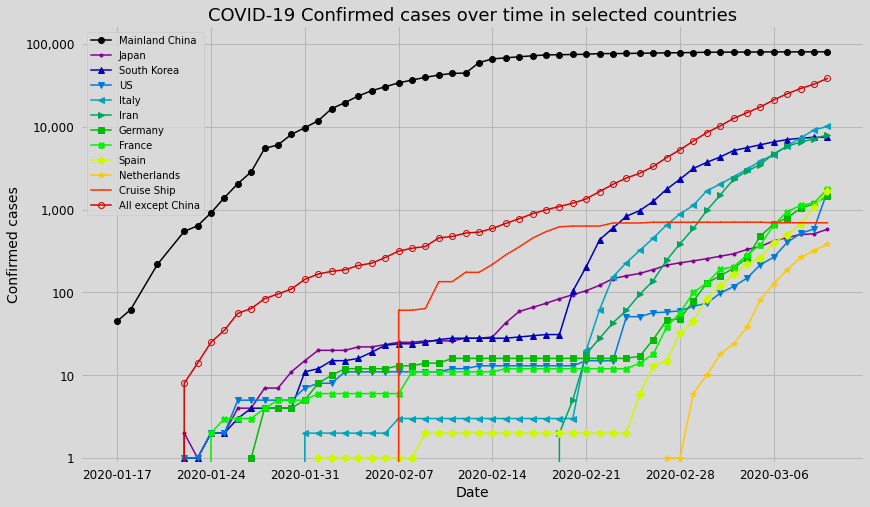

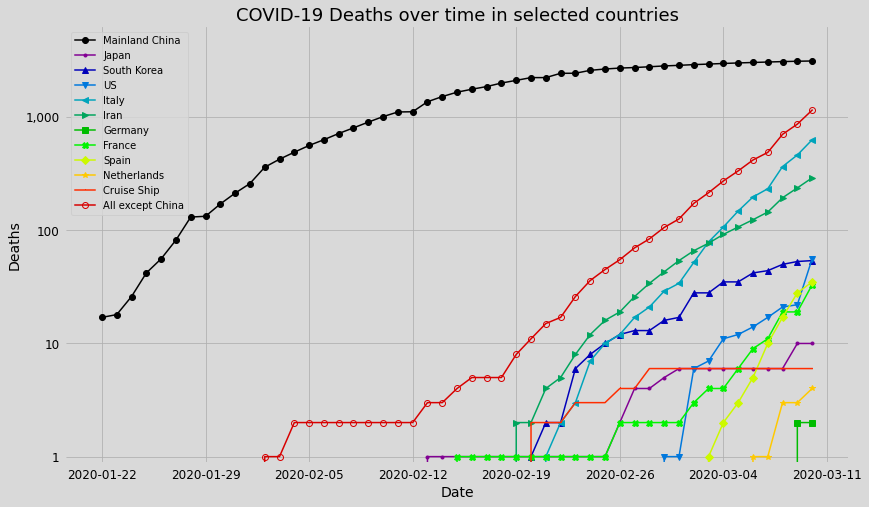

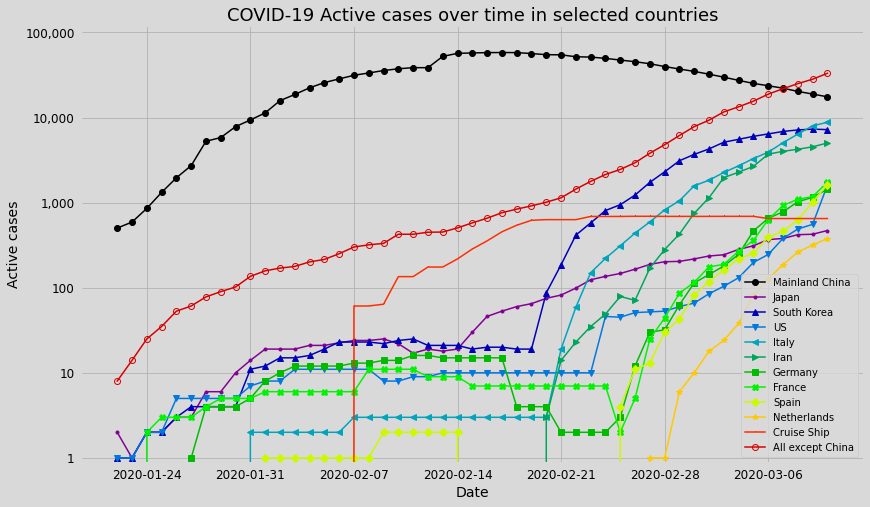

In [213]:
countries_to_plot = ["Mainland China", "Japan", "South Korea", "US", "Italy", "Iran", "Germany",
                     "France", "Spain", "Netherlands", "Cruise Ship", "All except China"]

for y_metric in ["confirmed", "deaths", "active"]:
    plot("calendar_date", y_metric, countries_to_plot)

### Plot cases over days since start of local outbreak in selected countries

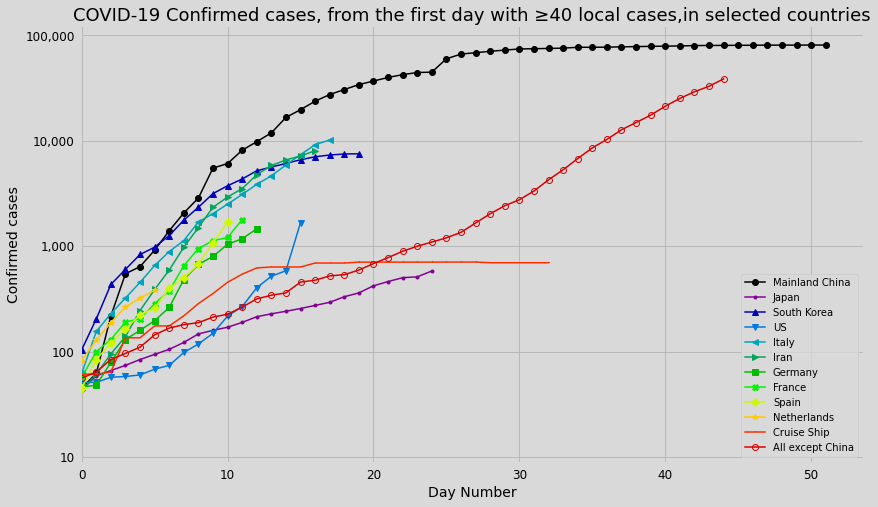

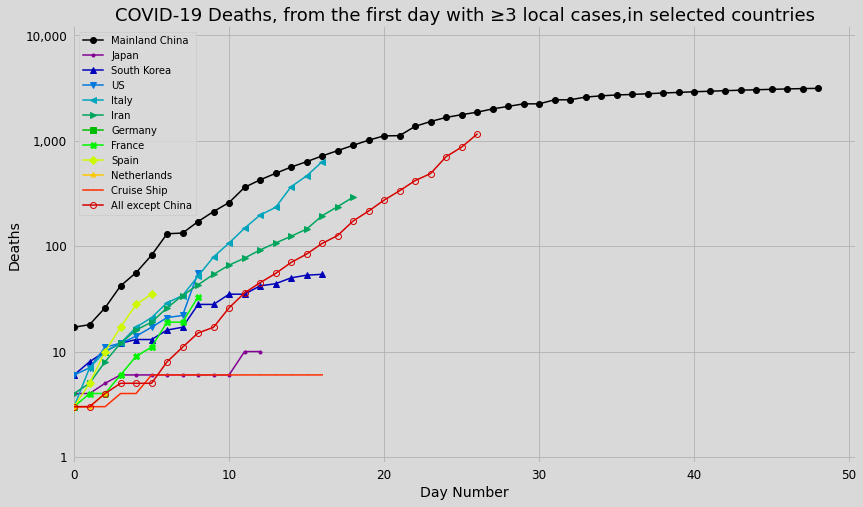

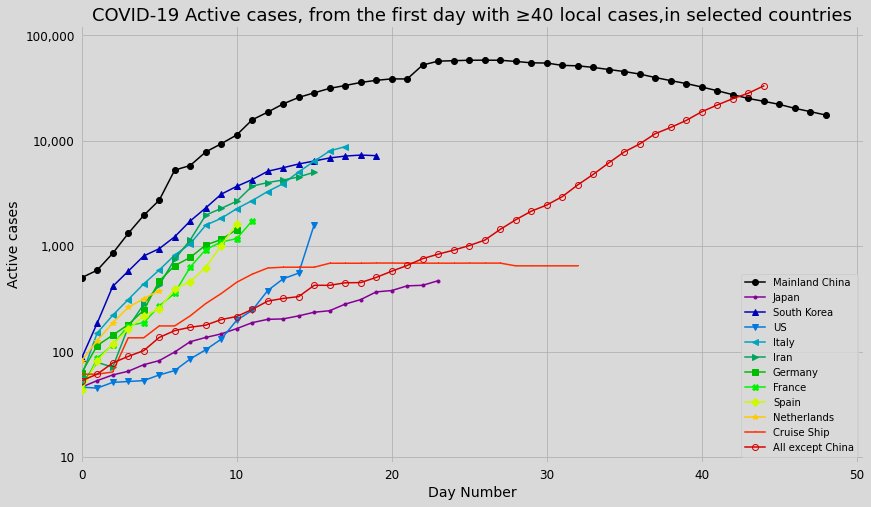

In [218]:
plot("day_number", "confirmed", countries_to_plot, min_cases=40)
plot("day_number", "deaths", countries_to_plot, min_cases=3)
plot("day_number", "active", countries_to_plot, min_cases=40)

### Smoothed growth factor

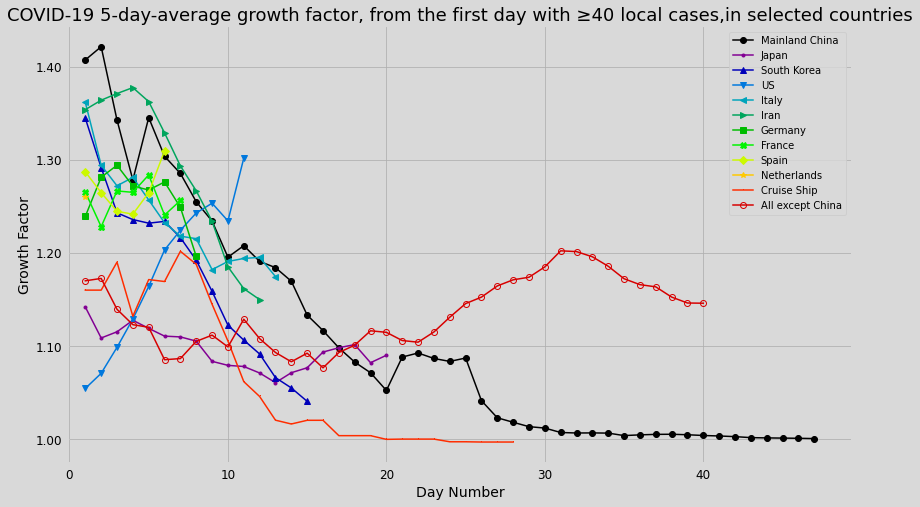

In [223]:
plot("day_number", "growth_factor", countries_to_plot)

### Confirmed cases, deaths and active cases in some other countries

This cell should be relatively easy to experiment in by changing the list of countries, or switching between logarithmic and linear scale.

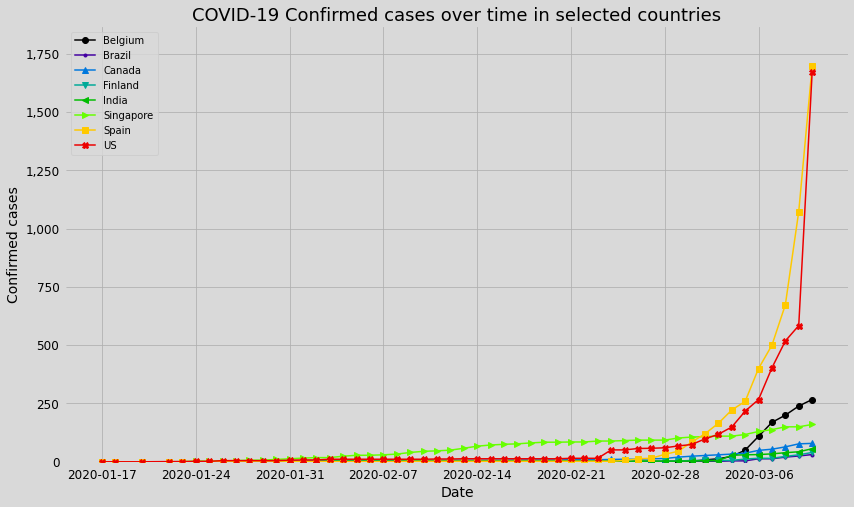

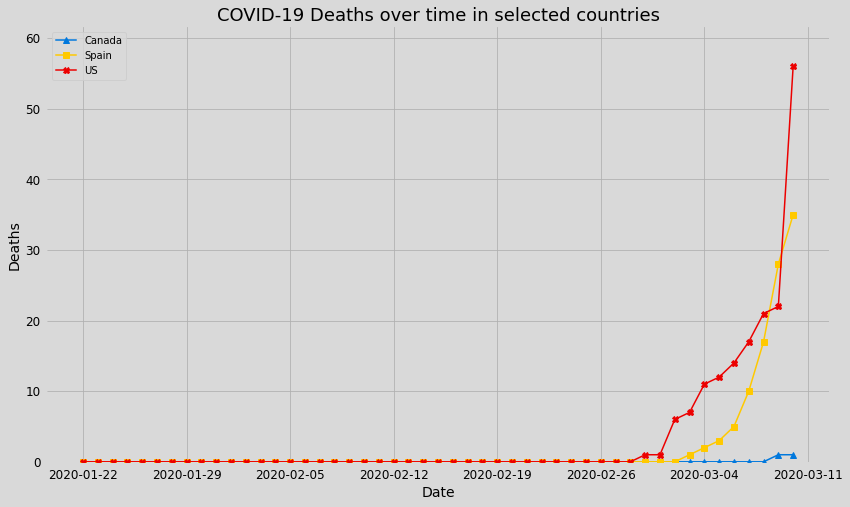

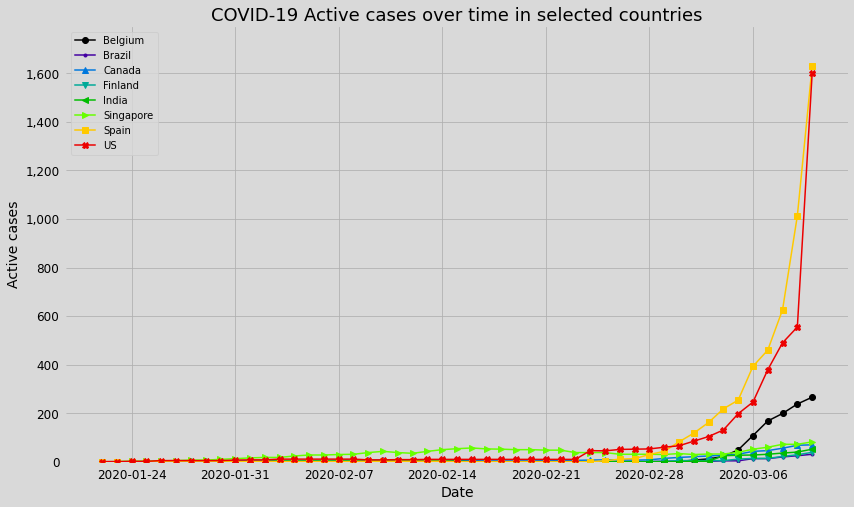

In [224]:
for y_metric in ["confirmed", "deaths", "active"]:
    plot("calendar_date", y_metric, 
         ["Belgium", "Brazil", "Canada", "Finland", "India", "Singapore", "Spain", "US"],
         use_log_scale=False)

### Fit a logistic curve and extrapolate number of future cases

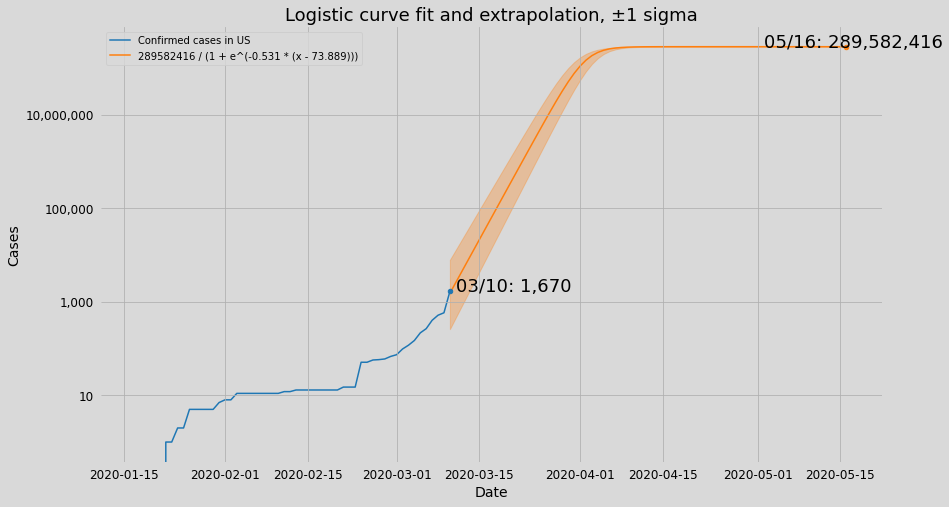

In [366]:
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def curve_fit(country="All except China", days=100, do_plot=True):
    x = np.arange(days)
    country_data = dataframes["confirmed_by_country"].loc[country, :]
    country_data = country_data[np.isfinite(country_data)]
    current_day = country_data.index[-1]
    
    [L, k, x0], pcov =  scipy.optimize.curve_fit(logistic_func, np.arange(len(country_data)), 
                                                 country_data, maxfev=10000, 
                                                 p0=[1e6, 0.5, max(1, 2*len(country_data))],
                                                 bounds=([0, 0.0, 1], [1e9, 1.0, 200]),
                                                 method="trf"
                                                )

    # dates up to 100 days after start
    model_date_list = [current_day + datetime.timedelta(days = n) for n in range(0, len(x) - len(country_data))] 
    model_date_list = [mdates.date2num(x) for x in model_date_list]

    n = len(model_date_list)
    sig_L, sig_k, sig_x0 = np.sqrt(np.diag(pcov))
    logistic = logistic_func(x[-n:]-1, L, k, x0)
    logistic_plus_sigma = logistic_func(x[-n:]-1, L+sig_L, k+sig_k, x0+sig_x0)
    logistic_minus_sigma = np.maximum(0, logistic_func(x[-n:]-1, L-sig_L, k-sig_k, x0-sig_x0))

    if do_plot:
        plt.plot(country_data, label="Confirmed cases in " + country, markersize=3, zorder=1)
        plt.plot(model_date_list, 
                 logistic, label=f"{L:.0f} / (1 + e^(-{k:.3f} * (x - {x0:.3f})))", zorder=1)
        plt.fill_between(model_date_list, logistic_minus_sigma, logistic_plus_sigma, alpha=0.3, color="C01")

        plt.grid()
        plt.legend(loc="upper left")
        plt.title("Logistic curve fit and extrapolation, ±1 sigma", fontsize=18)
        plt.xlabel("Date", fontsize=14)
        plt.ylabel("Cases", fontsize=14)
        plt.scatter(mdates.date2num(current_day), country_data[-1], s=20, c="C00", zorder=2)
        plt.annotate(f"{datetime.datetime.strftime(current_day, '%m/%d')}: {country_data[-1]:,.0f}", 
                     (mdates.date2num(current_day)+1, country_data[-1]), fontsize=18)

        plt.scatter(model_date_list[-1], logistic[-1], s=20, c="C01", zorder=2)
        plt.annotate(f"{mdates.num2date(model_date_list[-1]).strftime('%m/%d')}: {logistic[-1]:,.0f}", 
                     (model_date_list[-1]-14, logistic[-1]*0.94), fontsize=18)
        set_y_axis_format(True)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.gca().tick_params(which="both", color=light_grey)
        for spine in plt.gca().spines.values():
            spine.set_visible(False)
        plt.show()

    return country_data, model_date_list, logistic, logistic_plus_sigma, logistic_minus_sigma
    
curve_fit("US", days=120);

### Worldwide projection

For many countries, the curve fitting doesn't give very plausible results, so take this with many grains of salt.

D:\Programs\Miniconda3\envs\covid19\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


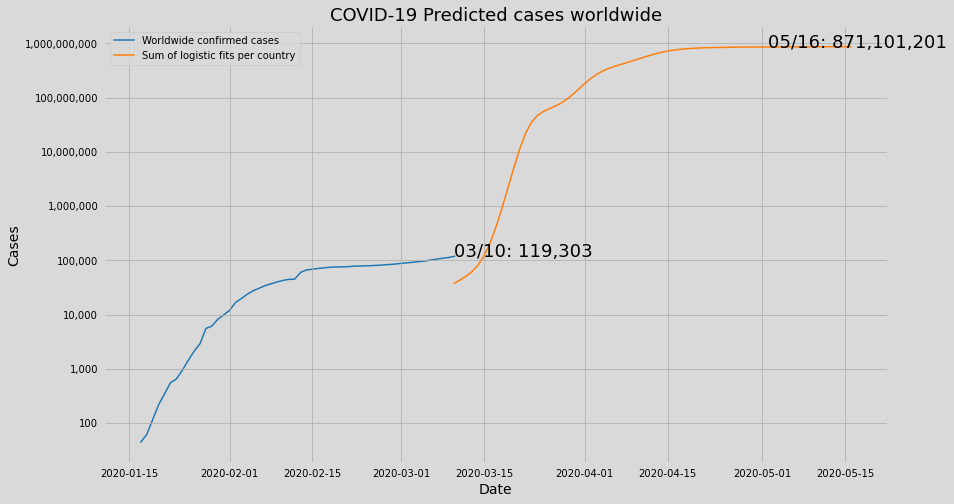

In [370]:
totals = {
    "model": [],
    "cases": [],
}


for country in confirmed_by_country.index:
    if country == "All except China": continue
    country_data, model_date_list, logistic, logistic_plus_sigma, logistic_minus_sigma =\
        curve_fit(country, days=120, do_plot=False)
    
    totals["model"] += [logistic]
    totals["cases"] += [country_data]

global_cases = np.sum(totals["cases"], axis=0)
global_predicted = np.sum(totals["model"], axis=0)
    
plt.plot(confirmed_by_country.columns,
         global_cases, 
         label="Worldwide confirmed cases", markersize=3, zorder=1)

plt.plot(mdates.num2date(model_date_list), 
         global_predicted, 
         label="Sum of logistic fits per country")

# Annotate current cases
plt.annotate(f"{confirmed_by_country.columns[-1].to_pydatetime().strftime('%m/%d')}: {global_cases[-1]:,.0f}", 
             (confirmed_by_country.columns[-1], global_cases[-1]), fontsize=18)

# Annotate final predicted cases
plt.annotate(f"{mdates.num2date(model_date_list[-1]).strftime('%m/%d')}: {global_predicted[-1]:,.0f}", 
         (model_date_list[-1]-14, global_predicted[-1]*0.94), fontsize=18)

set_y_axis_format(True)
plt.grid()
plt.legend(loc="upper left")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cases", fontsize=14)
plt.gca().tick_params(which="both", color=light_grey)
plt.title("COVID-19 Predicted cases worldwide", fontsize=18)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.show()